In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, SparsePCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sns.set_theme()
sns.set_context(font_scale=3)

df = pd.read_csv('../data/data.csv')

# remove informações que não são extraídas dos sinais de vibração
df.pop('rotacao_manual')
df.pop('severidade')

df['condicao'].replace({
    'normal': 'Normal',
    'vertical-misalignment':   'Desal. vertical',
    'horizontal-misalignment': 'Desal. horizontal',
    'imbalance': 'Desbalanceamento',
}, inplace=True)

output_map = {
    'Normal': 0,
    'Desal. vertical': 1,
    'Desal. horizontal': 2,
    'Desbalanceamento': 3,
}

df['condicao_num'] = df['condicao'].map(output_map)
df.sort_values(by='condicao_num', inplace=True)
df.rename(columns={'condicao': 'Condição'}, inplace=True)

# exibe lista de características
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 879 to 576
Columns: 111 entries, Condição to condicao_num
dtypes: float64(109), int64(1), object(1)
memory usage: 770.0+ KB


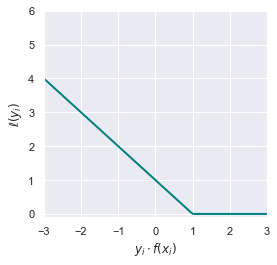

In [44]:
xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
lw = 2

font = {'size': 60}

matplotlib.rc('font', **font)

plt.figure(figsize=(4,3.8))
plt.plot(xx, np.where(xx < 1, 1 - xx, 0), color='teal', lw=lw,
         label="Hinge loss")

plt.ylim((-0.1, 6))
plt.xlim((-3, 3))
plt.xlabel(r"$y_i \cdot f(x_i)$")
plt.ylabel(r"$\ell(y_i)$")

plt.savefig('../redacao/figuras/hinge_loss.pdf', bbox_inches='tight')
plt.show()

## Todos os defeitos

<AxesSubplot:xlabel='ax2_timestat_peak', ylabel='Condição'>

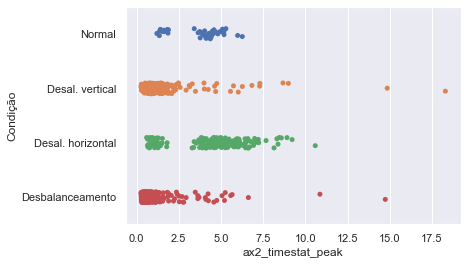

In [18]:
sns.stripplot(data=df, x='ax2_timestat_peak', y='Condição')


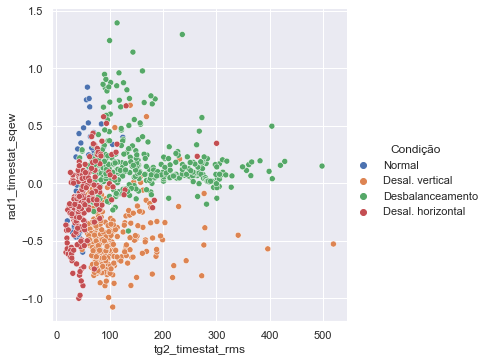

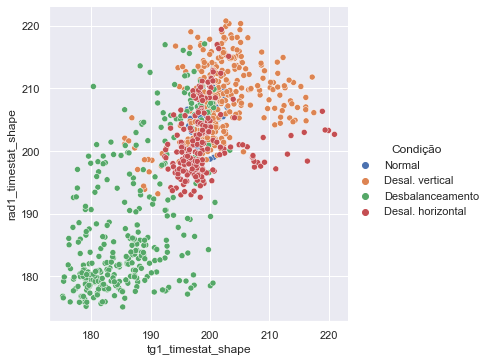

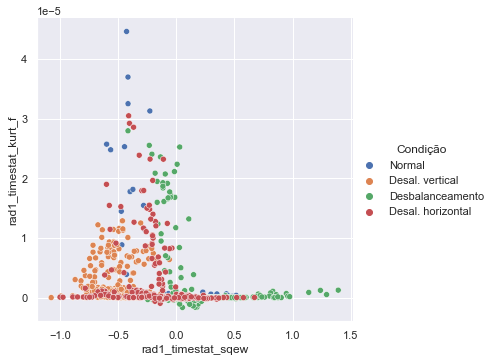

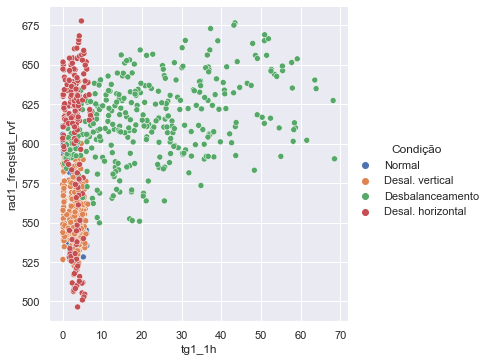

In [62]:
sns.relplot(data=df, x='tg2_timestat_rms', y='rad1_timestat_sqew', hue='Condição')
sns.relplot(data=df, x='tg1_timestat_shape', y='rad1_timestat_shape', hue='Condição')
sns.relplot(data=df, x='rad1_timestat_sqew', y='rad1_timestat_kurt_f', hue='Condição')
sns.relplot(data=df, x='tg1_1h', y='rad1_freqstat_rvf', hue='Condição')


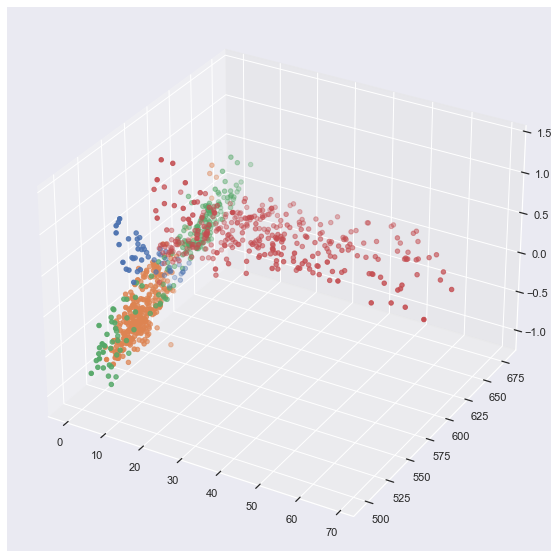

In [50]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for i, condicao in enumerate(output_map.keys()):
    df_cond = df.query(f'Condição == "{condicao}"')
    xs = df_cond['tg1_1h']
    ys = df_cond['rad1_freqstat_rvf']
    zs= df_cond['rad1_timestat_sqew']
    ax.scatter(xs, ys, zs, label=condicao)

In [52]:
def plot_pca_lda(X, y, target_names, n_outputs=4):
    
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)
    
#     pca_sparse = SparsePCA(n_components=2)
#     X_rsp = pca_sparse.fit(X).transform(X)
    
    if n_outputs == 2:
        lda = LinearDiscriminantAnalysis()
    else:
        lda = LinearDiscriminantAnalysis(n_components=2)
    X_r2 = lda.fit(X, y).transform(X)
    y_pred = lda.fit(X, y).predict(X)
    print(X_r2.shape)

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))

    plt.figure()
    colors = ['C0', 'C1', 'C2', 'C3'][:n_outputs]
    lw = 2

    for color, i, target_name in zip(colors, range(n_outputs), target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of dataset')

    plt.figure()
    if n_outputs == 2:
        for color, i, target_name in zip(colors, range(n_outputs), target_names):
            plt.scatter(X_r2[y == i], X_r2[y == i], alpha=.8, color=color,
                        label=target_name)
    else:
        for color, i, target_name in zip(colors, range(n_outputs), target_names):
            plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                        label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of dataset')

    plt.show()

(880, 2)
explained variance ratio (first two components): [0.4874855  0.17914736]


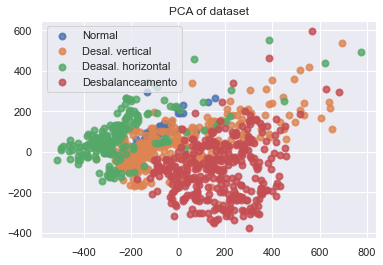

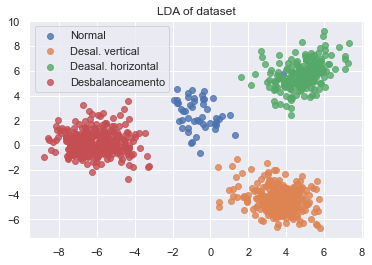

In [53]:
X = df.drop('Condição', axis = 1)
y = np.array(df['Condição'].map(output_map))
target_names = output_map.keys()

plot_pca_lda(X, y, target_names)

## Normal vs Defeituoso

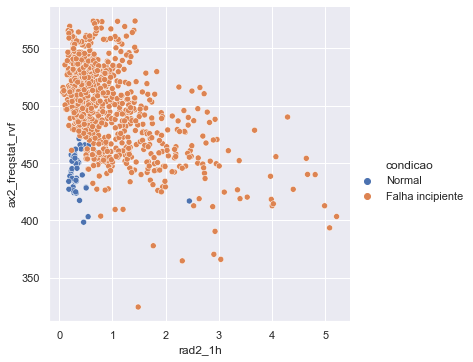

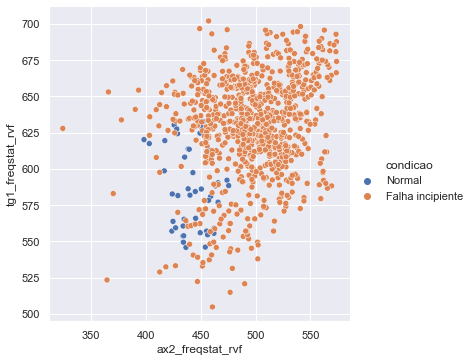

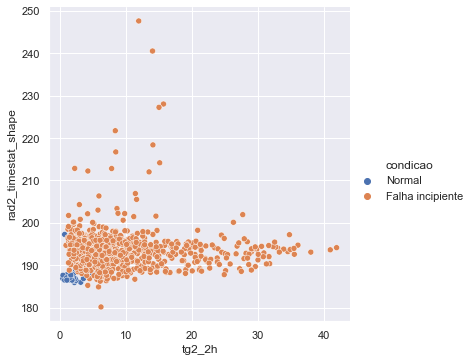

In [10]:
defect_map = {
    'imbalance': 'Falha incipiente',
    'vertical-misalignment': 'Falha incipiente',
    'horizontal-misalignment': 'Falha incipiente',
}
df_defect = df.copy()
df_defect['Condição'] = df['Condição'].map(defect_map)

sns.relplot(data=df_defect, x='rad2_1h', y='ax2_freqstat_rvf', hue='Condição')
sns.relplot(data=df_defect, x='ax2_freqstat_rvf', y='tg1_freqstat_rvf', hue='Condição')
sns.relplot(data=df_defect, x='tg2_2h', y='rad2_timestat_shape', hue='Condição')

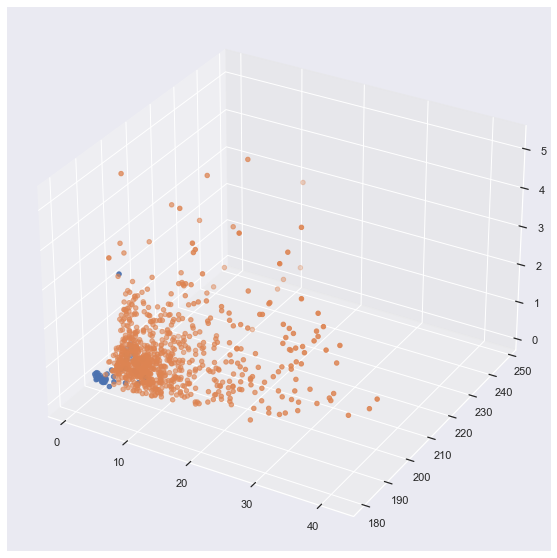

In [29]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for i, condicao in enumerate(['Normal', 'Falha incipiente']):
    df_cond = df_defect.query(f'Condição == "{condicao}"')
    xs = df_cond['tg2_2h']
    ys = df_cond['rad2_timestat_shape']
    zs= df_cond['rad2_1h']
    ax.scatter(xs, ys, zs, label=condicao)
    
ax.view_init(10,0)

(880, 1)
explained variance ratio (first two components): [0.4874855  0.17914736]


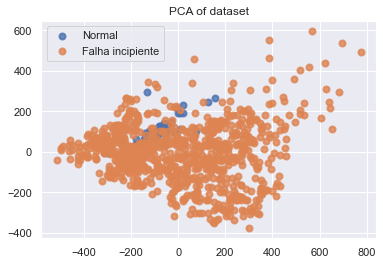

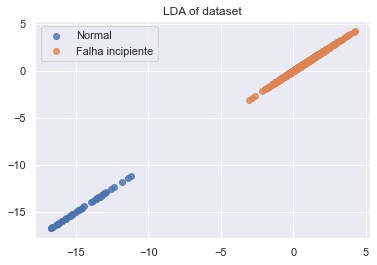

In [12]:
defect_map = {
    'Normal': 0,
    'Falha incipiente': 1,
}

X = df_defect.drop('Condição', axis = 1)
y = df_defect['Condição'].map(defect_map)
target_names = defect_map.keys()

plot_pca_lda(X, y, target_names, n_outputs=2)

## Desalinhamento horizontal vs vertical

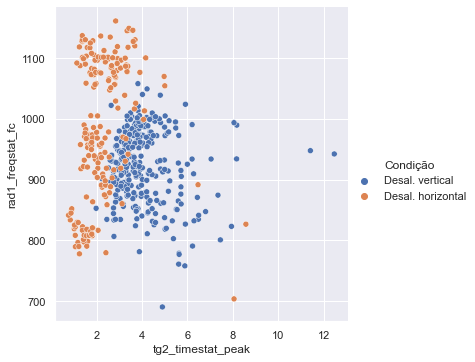

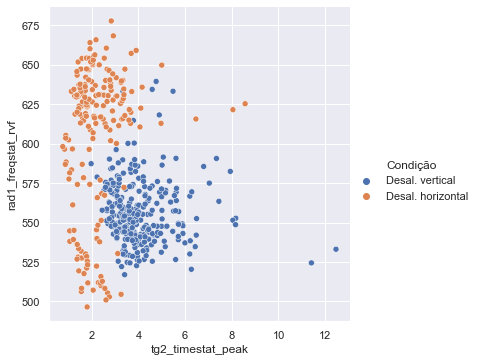

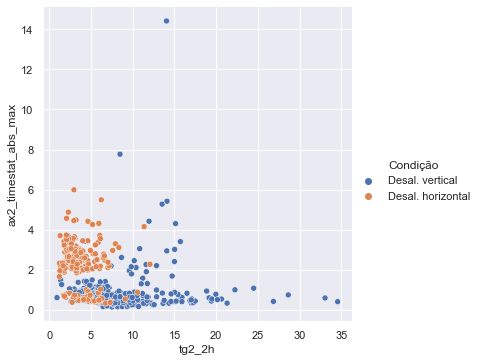

In [63]:
df_desal = df.query('Condição == "Desal. horizontal" | Condição == "Desal. vertical"')

sns.relplot(data=df_desal, x='tg2_timestat_peak', y='rad1_freqstat_fc', hue='Condição')
sns.relplot(data=df_desal, x='tg2_timestat_peak', y='rad1_freqstat_rvf', hue='Condição')
sns.relplot(data=df_desal, x='tg2_2h', y='ax2_timestat_abs_max', hue='Condição')

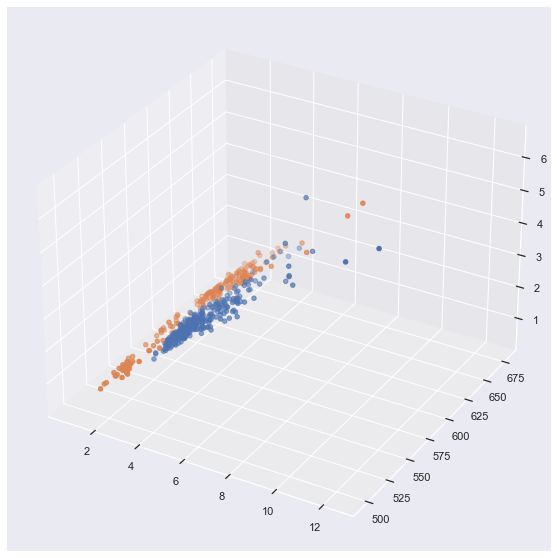

In [65]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for i, condicao in enumerate(["Desal. vertical", "Desal. horizontal"]):
    df_cond = df_desal.query(f'Condição == "{condicao}"')
    xs = df_cond['tg2_timestat_peak']
    ys = df_cond['rad1_freqstat_rvf']
    zs= df_cond['tg2_timestat_abs_max']
    ax.scatter(xs, ys, zs, label=condicao)

In [71]:
desal_map = {
    "Desal. vertical": 0,
    "Desal. horizontal": 1,
}

X = df_desal.drop('Condição', axis = 1)
y = df_desal['Condição'].map(desal_map)
target_names = desal_map.keys()


plot_pca_lda(X, y, target_names, n_outputs=2)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').